<a href="https://colab.research.google.com/github/AnkushRana528/SCT_ML_04/blob/main/SCT_ML_04_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Goal: Build a model that can identify and classify hand gestures from image data.**

# **Uploading and Unzipping the Dataset**

In [9]:
import zipfile
import os

# Defining the zip file path and extract location
zip_path = "/content/archive (1).zip"
extract_path = "/content/gesture_data"

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset unzipped successfully.")


✅ Dataset unzipped successfully.


# **Loading and preprocessing the images**

In [10]:
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

IMG_SIZE = 64  # Resize all images to 64x64
X = []
y = []

# Automatically find the dataset directory inside the extracted path
gesture_folder = extract_path
for root, dirs, files in os.walk(extract_path):
    if len(dirs) > 0:
        gesture_folder = root
        break

gesture_classes = [d for d in os.listdir(gesture_folder) if os.path.isdir(os.path.join(gesture_folder, d))]
label_dict = {name: idx for idx, name in enumerate(gesture_classes)}

print("Classes:", label_dict)

for gesture_name in tqdm(gesture_classes, desc="Loading images"):
    folder_path = os.path.join(gesture_folder, gesture_name)
    for file in os.listdir(folder_path):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                X.append(img)
                y.append(label_dict[gesture_name])

X = np.array(X)
y = np.array(y)

print("✅ Loaded images:", X.shape)
print("✅ Loaded labels:", y.shape)


Classes: {'valid': 0, 'test': 1, 'train': 2}


Loading images: 100%|██████████| 3/3 [00:08<00:00,  2.78s/it]

✅ Loaded images: (914, 64, 64, 3)
✅ Loaded labels: (914,)


# **Splitting into training and testing sets**

In [11]:
from sklearn.model_selection import train_test_split

# Normalize image pixels to [0,1]
X = X / 255.0

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Training samples:", X_train.shape)
print("✅ Testing samples:", X_test.shape)


✅ Training samples: (731, 64, 64, 3)
✅ Testing samples: (183, 64, 64, 3)


# **Building the CNN model**

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

num_classes = len(label_dict)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,539 (6.20 MB)

 Trainable params: 1,625,539 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

# **Training the model**

In [13]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32,
                    validation_data=(X_test, y_test))


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - accuracy: 0.6362 - loss: 0.9150 - val_accuracy: 0.6995 - val_loss: 0.8508
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.6929 - loss: 0.8489 - val_accuracy: 0.6995 - val_loss: 0.8230
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.7175 - loss: 0.7642 - val_accuracy: 0.6995 - val_loss: 0.8148
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - accuracy: 0.7125 - loss: 0.7887 - val_accuracy: 0.6995 - val_loss: 0.8256
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - accuracy: 0.7088 - loss: 0.7932 - val_accuracy: 0.6995 - val_loss: 0.8248
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step - accuracy: 0.6883 - loss: 0.8078 - val_accuracy: 0.6995 - val_loss: 0.8492
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 299ms/step - accuracy: 0.6951 - loss: 0.7728 - val_accuracy: 0.6995 - val_loss: 0.8319
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - accuracy: 0.7244 - loss: 0.7325 - val_accuracy: 0

# **Ploting accuracy/loss curves**

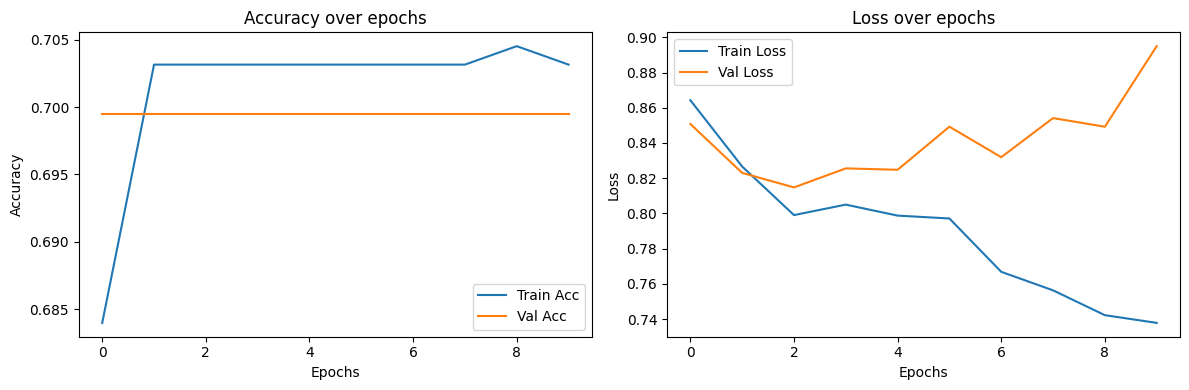

In [14]:
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# **Evaluating the model**

In [15]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {test_acc:.2f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7102 - loss: 0.8515
✅ Test Accuracy: 0.70


# **Saving the Model**

In [16]:
# Save the trained model to a file
model.save("gesture_recognition_model.h5")
print("✅ Model saved successfully!")


✅ Model saved successfully!
